In [1]:
import strax
import straxen
import wfsim
import nestpy
import numpy as np
import matplotlib.pyplot as plt 
from datetime import datetime

In [2]:
st = strax.Context(
        storage=strax.DataDirectory('./strax_data'),
        config=dict(
            fax_config=None,
            detector='XENON1T',
            **straxen.contexts.x1t_common_config),
        **straxen.contexts.common_opts)

In [3]:
st.register(wfsim.RawRecordsFromFax1T)

wfsim.strax_interface.RawRecordsFromFax1T

In [4]:
run_id = '203' #200 will be for Argon events here I used nr instead of er
                #nr would imply a neutron gets released, anything charged or photons is an er
                #201 did not seem to have the expected smeer, changing z intrustions for 202
                #202 worked well however I believe more events are needed, we need about 9x more events
    


In [5]:
def assign_labels(data, ref_img, xdim, ydim, cut_out):
    '''This functions takes in the data and classifications based on an image gives the
    unique labels as well as the data set bacl with the new classification
    PS this version only takes in S1s and S2s and ignores unclassified samples, 
    another version will be made to deal with the unclassified samples
    
    data: can be either peaks or peak_basics
    ref_img: will be the image extracted from the SOM classification of each data point
    xdim: width of the image cube
    ydim: height of the image cube
    cut_out: removes the n last digits of the image vector if necesarry'''
    img = Image.open(ref_img)
    imgGray = img.convert('L')
    #imgGray2.save('/home/luissanchez25/im_kr83_real__30x30_2lbl.0.rmpmap.png')
    img_color = np.array(img)
    img_color_2d = img_color.reshape((xdim*ydim,3))
    label = -1 * np.ones(img_color.shape[:-1])
    colorp = np.unique(img_color_2d, axis = 0)
    for i, color in enumerate(colorp):  # argwhere
        label[np.all((img_color == color), axis = 2)] = i
    label_vec = label.reshape((xdim*ydim))
    label_vec_nonzero = label_vec[:-cut_out]
    s2_data = data[data['type'] == 2]
    s1_data = data[data['type'] == 1]
    som_class_peaks = np.concatenate((s1_data,s2_data)) #note had to reverse s2,s1 to s1,s2
    som_class_peaks['type'] = label_vec_nonzero
    
    return colorp, som_class_peaks

In [6]:
def Argon_Kshell(c):
    """
    Instruction that is meant to simulate Kr83m events in the TPC.
    """
    import nestpy
    #half_life = 156.94e-9 # Kr intermediate state half-life in ns
    #decay_energies = [41.6] # Decay energies in KeV

    n = c['nevents'] = c['event_rate'] * c['chunk_size'] * c['nchunk']
    c['total_time'] = c['chunk_size'] * c['nchunk']

    # Uses 4*n to get the two energies for S1 and S2
    instructions = np.zeros(2*n,
                            dtype=wfsim.instruction_dtype) #instructions = np.zeros(2*n, dtype=wfsim.instruction_dtype)
    instructions['event_number'] = np.digitize(instructions['time'],
            1e9 * np.arange(c['nchunk']) * c['chunk_size']) - 1

    instructions['type'] = np.tile([1,2], n) # original instructions['type'] = np.tile([1,2], 2*n) eliminated one since im only interested in s2s
    instructions['recoil'] = ['er' for i in range(2*n)]# original instructions['recoil'] = ['er' for i in range(4*n)]

    #might need to reduce all 4's to 2's
    # Random positioning
    r = np.sqrt(np.random.uniform(0, c['tpc_radius']**2, n))
    t = np.random.uniform(-np.pi, np.pi, n)
    instructions['x'] = np.repeat(r * np.cos(t), 2)
    instructions['y'] = np.repeat(r * np.sin(t), 2)
    instructions['z'] = np.repeat(np.random.uniform(-100, 0, n), 2)
    # Choosing shallow z positioning

    # For correct times need to include the 156.94 ns half life of the intermediate state
    uniform_times = c['total_time'] * (np.arange(n) + 0.5) / n
    instructions['time'] = np.repeat(uniform_times, 2) * int(1e9)

    # Defining XENON-like detector
    nc = nestpy.NESTcalc(nestpy.VDetector())
    A = 131.293
    Z = 54
    density = 2.862 # g/cm^3    # SR1 Value
    drift_field = 82 # V/cm     # SR1 Value
    interaction = nestpy.INTERACTION_TYPE(7) # gamma

    energy = np.tile(2.8224, n)
    quanta = []
    for en in energy:
        y = nc.GetYields(interaction,
                en,
                density,
                drift_field,
                A,
                Z,
                (1,1))
        quanta.append(nc.GetQuanta(y, density).photons)
        quanta.append(nc.GetQuanta(y, density).electrons)

    instructions['amp'] = quanta

    return instructions

Argon_Kshell(dict(nchunk = 10, event_rate = 10, chunk_size=10, tpc_radius = 10))

array([(0, 1,    50000000, -8.497156 ,  0.51976025, -13.58849 , 126, 'er'),
       (0, 2,    50000000, -8.497156 ,  0.51976025, -13.58849 ,  87, 'er'),
       (0, 1,   150000000,  3.4693236,  1.2887025 , -45.873905, 113, 'er'),
       ...,
       (0, 2, 99850000000,  5.1411843,  7.8053837 , -68.161545,  88, 'er'),
       (0, 1, 99950000000, -0.6292011, -6.8931246 , -26.034983,  82, 'er'),
       (0, 2, 99950000000, -0.6292011, -6.8931246 , -26.034983,  88, 'er')],
      dtype=[('event_number', '<i4'), ('type', 'i1'), ('time', '<i8'), ('x', '<f4'), ('y', '<f4'), ('z', '<f4'), ('amp', '<i4'), ('recoil', '<U2')])

In [7]:
wfsim.strax_interface.rand_instructions = Argon_Kshell

In [8]:
st.set_config(dict(fax_config_override=dict(
            enable_noise=False,
            enable_pmt_afterpulses=False,
            enable_electron_afterpulses=False,)))

In [9]:
st.set_config(dict(fax_config='/data/xenon1t/fax_files/fax_config_1t_uniform_gains.json',
                   nchunk=30,
                   event_rate=30,
                   chunk_size=10))

In [10]:
peak_basics = st.get_array(run_id,'peak_basics')

/opt/conda/envs/didacts/lib/python3.8/site-packages/strax/context.py:589: UserWarning: Option channel_map not taken by any registered plugin
  plugins = self._get_plugins(targets, run_id)
/opt/conda/envs/didacts/lib/python3.8/site-packages/strax/context.py:1259: UserWarning: Option channel_map not taken by any registered plugin
  p = self._get_plugins((target,), run_id)[target]


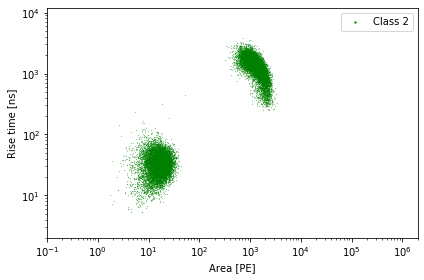

In [11]:
fig = plt.figure(figsize=(6,4))
#plt.scatter(class0_2['area'],class0_2['rise_time'], s= 0.1, marker='.',color='b', label = "Class 1")
plt.scatter(peak_basics['area'],peak_basics['rise_time'], s= 0.1, marker='.',color='g', label = "Class 2")
#plt.scatter(class3_2['length'],class3_2['rise_time'], s= 0.1, marker='.',color='orange', label = "Class 3")
#plt.scatter(class2['area'],class2['rise_time'], s= 0.1, marker='.',color='red')
plt.yscale('log')
plt.ylim(2,12000)
plt.xlim(0.1,2e6)
plt.xscale('log')
plt.xlabel('Area [PE]')#, fontsize = 30)
plt.ylabel('Rise time [ns]')#, fontsize = 30)
plt.legend(markerscale=8)#, fontsize = 24)
plt.tight_layout()
#plt.savefig('Checks/kr83_real_data_3lbl_SOM_class.pdf')
plt.show()

In [12]:
#Now lets simulate the L-shell
def Argon_Lshell(c):
    """
    Instruction that is meant to simulate Argon Lshell events in the TPC.
    This set of code can only generate S2s due to the S1s having 0 amplitude
    """
    import nestpy
    #half_life = 156.94e-9 # Kr intermediate state half-life in ns
    #decay_energies = [41.6] # Decay energies in KeV

    n = c['nevents'] = c['event_rate'] * c['chunk_size'] * c['nchunk']
    c['total_time'] = c['chunk_size'] * c['nchunk']

    # Uses 4*n to get the two energies for S1 and S2
    instructions = np.zeros(n,
                            dtype=wfsim.instruction_dtype) #instructions = np.zeros(2*n, dtype=wfsim.instruction_dtype)
    instructions['event_number'] = np.digitize(instructions['time'],
            1e9 * np.arange(c['nchunk']) * c['chunk_size']) - 1

    instructions['type'] = np.tile([2], n) # original instructions['type'] = np.tile([1,2], 2*n) eliminated one since im only interested in s2s
    instructions['recoil'] = ['er' for i in range(n)]# original instructions['recoil'] = ['er' for i in range(4*n)]

    #might need to reduce all 4's to 2's
    # Random positioning
    r = np.sqrt(np.random.uniform(0, c['tpc_radius']**2, n))
    t = np.random.uniform(-np.pi, np.pi, n)
    instructions['x'] = np.repeat(r * np.cos(t), 1)
    instructions['y'] = np.repeat(r * np.sin(t), 1)
    instructions['z'] = np.repeat(np.random.uniform(-100, 0, n), 1)
    # Choosing shallow z positioning

    # For correct times need to include the 156.94 ns half life of the intermediate state
    uniform_times = c['total_time'] * (np.arange(n) + 0.5) / n
    instructions['time'] = np.repeat(uniform_times, 1) * int(1e9)

    # Defining XENON-like detector
    nc = nestpy.NESTcalc(nestpy.VDetector())
    A = 131.293
    Z = 54
    density = 2.862 # g/cm^3    # SR1 Value
    drift_field = 82 # V/cm     # SR1 Value
    interaction = nestpy.INTERACTION_TYPE(7) # gamma

    energy = np.tile(0.2702, n)
    quanta = []
    for en in energy:
        y = nc.GetYields(interaction,
                en,
                density,
                drift_field,
                A,
                Z,
                (1,1))
        #quanta.append(nc.GetQuanta(y, density).photons)
        quanta.append(nc.GetQuanta(y, density).electrons)
    
    #print(quanta)
    instructions['amp'] = quanta

    return instructions

#Argon_Lshell(dict(nchunk = 10, event_rate = 10, chunk_size=10, tpc_radius = 10))

In [13]:
Lshell_id = '250'

In [14]:
wfsim.strax_interface.rand_instructions = Argon_Lshell

In [15]:
st.set_config(dict(fax_config_override=dict(
            enable_noise=False,
            enable_pmt_afterpulses=False,
            enable_electron_afterpulses=False,)))

In [16]:
st.set_config(dict(fax_config='/data/xenon1t/fax_files/fax_config_1t_uniform_gains.json',
                   nchunk=10,
                   event_rate=10,
                   chunk_size=10))

In [17]:
peak_basics_Lshell = st.get_array(Lshell_id,'peak_basics')

/opt/conda/envs/didacts/lib/python3.8/site-packages/strax/context.py:589: UserWarning: Option channel_map not taken by any registered plugin
  plugins = self._get_plugins(targets, run_id)
/opt/conda/envs/didacts/lib/python3.8/site-packages/strax/context.py:1259: UserWarning: Option channel_map not taken by any registered plugin
  p = self._get_plugins((target,), run_id)[target]


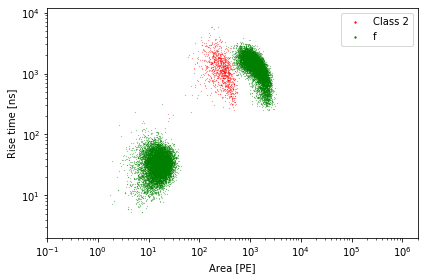

In [18]:
fig = plt.figure(figsize=(6,4))
#plt.scatter(class0_2['area'],class0_2['rise_time'], s= 0.1, marker='.',color='b', label = "Class 1")
plt.scatter(peak_basics_Lshell['area'],peak_basics_Lshell['rise_time'], s= 0.1, marker='.',color='r', label = "Class 2")
plt.scatter(peak_basics['area'],peak_basics['rise_time'], s= 0.1, marker='.',color='g', label = "f")
#plt.scatter(class3_2['length'],class3_2['rise_time'], s= 0.1, marker='.',color='orange', label = "Class 3")
#plt.scatter(class2['area'],class2['rise_time'], s= 0.1, marker='.',color='red')
plt.yscale('log')
plt.ylim(2,12000)
plt.xlim(0.1,2e6)
plt.xscale('log')
plt.xlabel('Area [PE]')#, fontsize = 30)
plt.ylabel('Rise time [ns]')#, fontsize = 30)
plt.legend(markerscale=8)#, fontsize = 24)
plt.tight_layout()
#plt.savefig('Checks/kr83_real_data_3lbl_SOM_class.pdf')
plt.show()

In [19]:
peaks_Kshell = st.get_array(run_id, 'peaks')

In [20]:
peaks_Lshell = st.get_array(Lshell_id, 'peaks')

/opt/conda/envs/didacts/lib/python3.8/site-packages/strax/context.py:589: UserWarning: Option channel_map not taken by any registered plugin
  plugins = self._get_plugins(targets, run_id)
/opt/conda/envs/didacts/lib/python3.8/site-packages/strax/context.py:1259: UserWarning: Option channel_map not taken by any registered plugin
  p = self._get_plugins((target,), run_id)[target]


In [21]:
def dump_matched_peaks(run_id, truth, peaks, peak_basics):#, int_type):
    """
    Dump matched peaks in a human readable format
    param run_id: run_id
    param truth: truth array to be matched
    param peaks: peaks array to be matched
    return data: np.array with the matched peaks and true info
    """
    #  This is for single electrons
    #if int_type == 1:
    #    truth = truth[truth['n_electron'] == 1]

    #  for now focus on S2
    s2_truth = truth
    s2_peaks = peaks
    s2_peak_basics = peak_basics

    #  This is first attemp to match peaks and true info
    mask = np.zeros(len(s2_peak_basics), dtype=np.bool)
    for i, t in enumerate(s2_truth):
        mask += ((s2_peak_basics['time'] < t['t_mean_photon']) &
                 (s2_peak_basics['endtime'] > t['t_mean_photon']))

    s2_matched = s2_peaks[mask]
    s2_peak_basics = s2_peak_basics[mask]

    #   Do not ask me why... sometimes life is hard...
    if len(s2_matched['time']) != len(s2_truth['time']):
        s2_matched, s2_peak_basics, s2_truth = match_events(s2_matched, s2_peak_basics, s2_truth)

    '''data = np.zeros(len(s2_matched),
                    dtype=[('run_id', '<i8'), ('center_time', '<i8'), ('area', '<f8'), ('area_per_channel', '<f8', (248, )),
                           ('data', '<f8', (200, )), ('n_saturated_channels', '<i8'), ('n_electrons', '<i8'),
                           ('n_photons', '<i8'), ('amp', '<i8'), ('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('t', '<i8')])

    data['run_id'] = np.repeat(run_id, len(s2_matched))
    data['center_time'] = s2_peak_basics['center_time']
    data['area'] = s2_matched['area']
    data['area_per_channel'] = s2_matched['area_per_channel']
    data['data'] = s2_matched['data']
    data['n_saturated_channels'] = s2_matched['n_saturated_channels']
    data['n_electrons'] = s2_truth['n_electron']
    data['n_photons'] = s2_truth['n_photon']
    data['amp'] = s2_truth['amp']
    data['x'] = s2_truth['x']
    data['y'] = s2_truth['y']
    data['z'] = s2_truth['z']
    data['t'] = s2_truth['t_mean_photon']'''

    return s2_matched, s2_peak_basics, s2_truth

In [22]:
def match_events(s2_matched, s2_peak_basics, s2_truth):
    """
    Match s2 peaks with s2 true info
    param s2_matched: s2 peak array
    param s2_peak_basics: s2 peak_basic array
    param s2_truth: s2 truth array
    param return: s2_ms2_matched, s2_peak_basics, s2_truth matched arrays
    """
    matched = []
    matched_t = []
    for i, p in enumerate(s2_peak_basics):
        for j, t in enumerate(s2_truth):
            if abs(p['center_time']-t['t_mean_photon']) < 200:  # 200 ns window
                matched.append(i)
                matched_t.append(j)
                break

    s2_matched = np.take(s2_matched, matched)
    s2_peak_basics = np.take(s2_peak_basics, matched)
    s2_truth = np.take(s2_truth, matched_t)

    return s2_matched, s2_peak_basics, s2_truth

In [23]:
kshell_truth = st.get_array(run_id, 'truth')

In [24]:
lshell_truth = st.get_array(Lshell_id, 'truth')

/opt/conda/envs/didacts/lib/python3.8/site-packages/strax/context.py:589: UserWarning: Option channel_map not taken by any registered plugin
  plugins = self._get_plugins(targets, run_id)
/opt/conda/envs/didacts/lib/python3.8/site-packages/strax/context.py:1259: UserWarning: Option channel_map not taken by any registered plugin
  p = self._get_plugins((target,), run_id)[target]


In [95]:
kmatched_peaks, kmatched_peak_basics, kmatched_truth = dump_matched_peaks(run_id,kshell_truth,peaks_Kshell,peak_basics)

<ipython-input-21-025893e468c2>:21: RuntimeWarning: invalid value encountered in less
  mask += ((s2_peak_basics['time'] < t['t_mean_photon']) &
<ipython-input-21-025893e468c2>:22: RuntimeWarning: invalid value encountered in greater
  (s2_peak_basics['endtime'] > t['t_mean_photon']))


In [26]:
lmatched_peaks, lmatched_peak_basics, lmatched_truth = dump_matched_peaks(Lshell_id,lshell_truth,peaks_Lshell,peak_basics_Lshell)

In [32]:
kmathched_peaks_true = kmatched_peaks
kmathched_peaks_true['type'] = kmatched_truth['type']
kmathched_peaks_true['data'] = np.where(kmathched_peaks_true['data']<0, 0, kmathched_peaks_true['data'])

In [33]:
lmathched_peaks_true = lmatched_peaks
lmathched_peaks_true['type'] = lmatched_truth['type']
lmathched_peaks_true['data'] = np.where(lmathched_peaks_true['data']<0, 0, lmathched_peaks_true['data'])

In [56]:
kmatched_pb_t = kmatched_peak_basics
kmatched_pb_t['type'] = kmatched_truth['type']

In [57]:
lmatched_pb_t = lmatched_peak_basics
lmatched_pb_t['type'] = lmatched_truth['type']

In [58]:
kpb_s1 = kmatched_pb_t[kmatched_pb_t['type']==1]
kpb_s2= kmatched_pb_t[kmatched_pb_t['type']==2]

In [60]:
kpb = np.concatenate((kpb_s2,kpb_s1))

In [59]:
lpb_s1 = lmatched_pb_t[lmatched_pb_t['type']==1]
lpb_s2 = lmatched_pb_t[lmatched_pb_t['type']==2]

In [61]:
lpb = np.concatenate((lpb_s2,lpb_s1))

In [34]:
kpeaks_s1 = kmathched_peaks_true[kmathched_peaks_true['type'] == 1]
kpeaks_s2 = kmathched_peaks_true[kmathched_peaks_true['type'] == 2]

In [35]:
lpeaks_s1 = lmathched_peaks_true[lmathched_peaks_true['type'] == 1]
lpeaks_s2 = lmathched_peaks_true[lmathched_peaks_true['type'] == 2]

In [31]:
#L1 normalize and save the data as a raw file
S2_kshell_L1 = np.zeros((np.shape(kpeaks_s2['data'])))
for aa in np.arange(len(kpeaks_s2['data'][:,1])):
    S2_kshell_L1[aa,:] = kpeaks_s2['data'][aa,:]/np.sum(kpeaks_s2['data'][aa,:])
    
S1_kshell_L1 = np.zeros((np.shape(kpeaks_s1['data'])))
for aa in np.arange(len(kpeaks_s1['data'][:,1])):
    S1_kshell_L1[aa,:] = kpeaks_s1['data'][aa,:]/np.sum(kpeaks_s1['data'][aa,:])

In [32]:
S2_lshell_L1 = np.zeros((np.shape(lpeaks_s2['data'])))
for aa in np.arange(len(lpeaks_s2['data'][:,1])):
    S2_lshell_L1[aa,:] = lpeaks_s2['data'][aa,:]/np.sum(lpeaks_s2['data'][aa,:])

In [33]:
S2_kshell_L1 = np.array(S2_kshell_L1)
S1_kshell_L1 = np.array(S1_kshell_L1)
S2_lshell_L1 = np.array(S2_lshell_L1)

In [108]:
np.shape(S2_kshell_L1)

(8716, 200)

In [109]:
np.shape(S1_kshell_L1)

(8992, 200)

In [101]:
S2_kshell_L1[50,:].sum()

1.0000000261052264

In [104]:
np.size(lpeaks_s2)

957

In [110]:
kshell_L1 = np.concatenate((S2_kshell_L1,S1_kshell_L1))

In [111]:
np.shape(kshell_L1)

(17708, 200)

In [112]:
from functools import reduce

def factors(n):    
    return set(reduce(list.__add__, 
                ([i, n//i] for i in range(1, int(n**0.5) + 1) if n % i == 0)))

In [113]:
factors(17708)

{1, 2, 4, 19, 38, 76, 233, 466, 932, 4427, 8854, 17708}

In [115]:
233*76

17708

In [116]:
np.shape(S2_lshell_L1)

(957, 200)

In [118]:
factors(957)

{1, 3, 11, 29, 33, 87, 319, 957}

In [119]:
29*33

957

In [121]:
kshell_L1  = kshell_L1.astype('float32')
kshell_L1_vec = np.reshape(kshell_L1 ,(len(kshell_L1[1,:])*(len(kshell_L1[:,1]))))

In [122]:
import struct

f=open("Argon_kshell_data_L1.raw","wb")
export_TL = kshell_L1_vec
myfmt='f'*len(export_TL)
#  You can use 'd' for double and < or > to force endinness
bin=struct.pack(myfmt,*export_TL)
f.write(bin)
f.close()

In [123]:
lshell_L1  = S2_lshell_L1.astype('float32')
lshell_L1_vec = np.reshape(lshell_L1 ,(len(lshell_L1[1,:])*(len(lshell_L1[:,1]))))

In [124]:
import struct

f=open("Argon_lshell_data_L1.raw","wb")
export_TL = lshell_L1_vec
myfmt='f'*len(export_TL)
#  You can use 'd' for double and < or > to force endinness
bin=struct.pack(myfmt,*export_TL)
f.write(bin)
f.close()

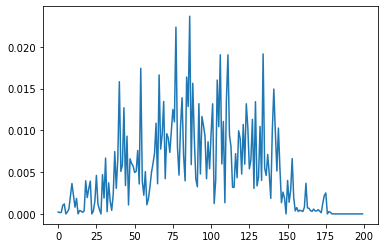

In [126]:
plt.plot(lshell_L1[20,:])

In [141]:
class_nums = [8761, 8761+8992, 1e10]
def generate_incl_file(filename, xcube, ycube, class_nums):
    #example 233 x and 76 y with S2s being 8716 and S1s being 8992
    f = open(filename, "w+")
    count = 1
    for i in np.arange(ycube):
        for j in np.arange(xcube):
            if count <= class_nums[0]:
                f.write('include area ' 
                        +str(j+1) + ' ' 
                        +str(i+1) + ' ' 
                        +str(j+1) + ' ' 
                        +str(i+1) + ' C' + ' \n')
            if count > class_nums[0] and count <= class_nums[1]:
                f.write('include area ' 
                        +str(j+1) + ' ' 
                        +str(i+1) + ' ' 
                        +str(j+1) + ' ' 
                        +str(i+1) + ' G' + '\n')
            if count > class_nums[1]:
                f.write('include area ' 
                        +str(j+1) + ' ' 
                        +str(i+1) + ' ' 
                        +str(j+1) + ' ' 
                        +str(i+1) + ' H' + '\n')
            count = count + 1
    f.close()

In [142]:
generate_incl_file("Argon_kshell_incl.txt",233,76,class_nums)

This section of the code will be for upsampling the data and outputing the .raw files

In [42]:
def upsample_data(wfdata, max_dt):
    #this function takes in waveforms of different dts and upsamples them by repeating
    #the elements by the dt value and padding with zeros when necessary
    #Max dt is just the largest dt to use
    data = wfdata['data'].copy()
    dt = wfdata['dt'].copy() // 10 # Integer divide by 10 ns
    #max_dt = 8 # units of 10 ns
    assert dt.max() <= max_dt

    # This will be where the padded waveforms go
    S2_padded_data = np.zeros((data.shape[0],
                            data.shape[1]*max_dt))

    for value in np.unique(dt): 
        # Just pick waveforms with dt of some value, where this is the mask
        selection = dt == value

    # Fill required values in the padded data
        S2_padded_data[selection, 0:value*200] = np.repeat(data[selection],
                                                        value,
                                                        axis=1,)
    return S2_padded_data

In [36]:
def recombine_data(s2,s1,num_0_vec):
    [A,B] = np.shape(s2)
    s2s1 = np.concatenate((s2,s1))
    #s2s1s0 = np.concatenate((s2s1,s0))
    data = np.concatenate((s2s1,np.zeros((num_0_vec,B))))
    return data

In [47]:
def export_data(data, export_name):
    data_vec = np.reshape(data, (len(data[1,:])*len(data[:,1])))
    
    import struct

    f=open(export_name,"wb")
    export_TL = data_vec
    export_TL.dtype
    myfmt='f'*len(export_TL)
    #  You can use 'd' for double and < or > to force endinness
    bin=struct.pack(myfmt,*export_TL)
    f.write(bin)
    f.close()
    #export name must be a string with the extnesion.raw

In [39]:
Kshell_data = np.concatenate((kpeaks_s2,kpeaks_s1))

In [43]:
Kshell_data_upsampled = upsample_data(Kshell_data, 8)

In [38]:
np.shape(Kshell_data_upsampled)

NameError: name 'Kshell_data_upsampled' is not defined

In [48]:
export_data(Kshell_data_upsampled, "Kshell_sim_data_upsampled.raw")

In [111]:
Lshell_data = np.concatenate((lpeaks_s2,lpeaks_s1))

In [50]:
Lshell_data_upsampled = upsample_data(Lshell_data, 8)

In [51]:
np.shape(Lshell_data_upsampled)

(957, 1600)

In [52]:
export_data(Lshell_data_upsampled, "Lshell_sim_data_upsampled.raw")

In [71]:
def assign_labels(data, ref_img, xdim, ydim, cut_out):
    '''This functions takes in the data and classifications based on an image gives the
    unique labels as well as the data set bacl with the new classification
    PS this version only takes in S1s and S2s and ignores unclassified samples, 
    another version will be made to deal with the unclassified samples
    
    data: can be either peaks or peak_basics
    ref_img: will be the image extracted from the SOM classification of each data point
    xdim: width of the image cube
    ydim: height of the image cube
    cut_out: removes the n last digits of the image vector if necesarry'''
    from PIL import Image
    img = Image.open(ref_img)
    imgGray = img.convert('L')
    #imgGray2.save('/home/luissanchez25/im_kr83_real__30x30_2lbl.0.rmpmap.png')
    img_color = np.array(img)
    img_color_2d = img_color.reshape((xdim*ydim,3))
    label = -1 * np.ones(img_color.shape[:-1])
    colorp = np.unique(img_color_2d, axis = 0)
    for i, color in enumerate(colorp):  # argwhere
        label[np.all((img_color == color), axis = 2)] = i
    label_vec = label.reshape((xdim*ydim))
    if cut_out != 0:
        label_vec_nonzero = label_vec[:-cut_out]
    elif cut_out == 0:
        label_vec_nonzero = label_vec
    s2_data = data[data['type'] == 2]
    s1_data = data[data['type'] == 1]
    som_class_peaks = np.concatenate((s2_data,s1_data)) #note had to reverse s2,s1 to s1,s2
    som_class_peaks['type'] = label_vec_nonzero
    
    return colorp, som_class_peaks

This section of the code will be for processing the results of the data from the SOM

In [80]:
kshell_colors, kshell_labels = assign_labels(kpb,'im_kr83realSOM_ArKshellmap_vs.0.rmpmap.png',233,76,0)

In [73]:
class0_ark = kshell_labels[kshell_labels['type'] == 0]
class1_ark = kshell_labels[kshell_labels['type'] == 1]
class2_ark = kshell_labels[kshell_labels['type'] == 2]
class3_ark = kshell_labels[kshell_labels['type'] == 3]
class4_ark = kshell_labels[kshell_labels['type'] == 4]

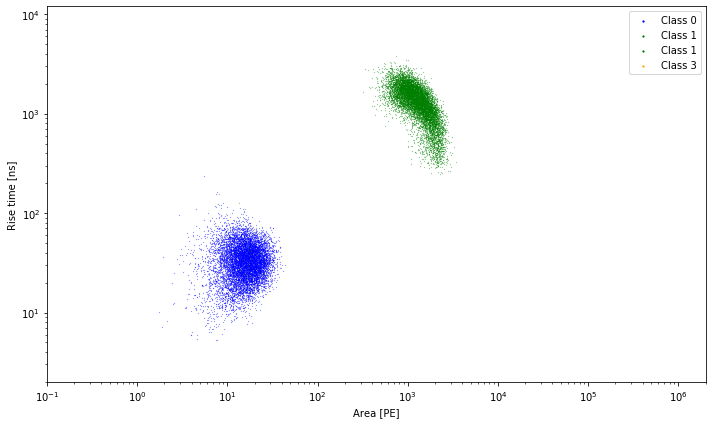

In [77]:
fig = plt.figure(figsize=(10,6))
plt.scatter(class0_ark['area'],class0_ark['rise_time'], s= 0.1, marker='.',color='b', label = 'Class 0')
plt.scatter(class1_ark['area'],class1_ark['rise_time'], s= 0.1, marker='.',color='g', label = 'Class 1')
plt.scatter(class3_ark['area'],class3_ark['rise_time'], s= 0.1, marker='.',color='green', label = 'Class 1')
plt.scatter(class4_ark['area'],class4_ark['rise_time'], s= 0.1, marker='.',color='orange', label = 'Class 3')
#plt.scatter(class2['area'],class2['rise_time'], s= 0.1, marker='.',color='red')
plt.yscale('log')
plt.ylim(2,12000)
plt.xlim(0.1,2e6)
plt.xscale('log')
plt.xlabel('Area [PE]')#, fontsize = 30)
plt.ylabel('Rise time [ns]')#, fontsize = 30)
plt.legend(markerscale=8)#, fontsize = 24)
plt.tight_layout()
#plt.savefig('Checks/kr83_real_data_2lbl_SOM_class.pdf')
plt.show()

In [130]:
lshell_colors, lshell_labels = assign_labels(lpb,'im_kr83realSOM_ArLshell_test.0.rmpmap.png',33,29,0)

In [120]:
lshell_colors

array([[  0,   0, 255],
       [  0, 255,   0],
       [254, 146,  43]], dtype=uint8)

In [68]:
class0_arl = lshell_labels[lshell_labels['type'] == 0]
class1_arl = lshell_labels[lshell_labels['type'] == 1]
class2_arl = lshell_labels[lshell_labels['type'] == 2]
class3_arl = lshell_labels[lshell_labels['type'] == 3]
class4_arl = lshell_labels[lshell_labels['type'] == 4]

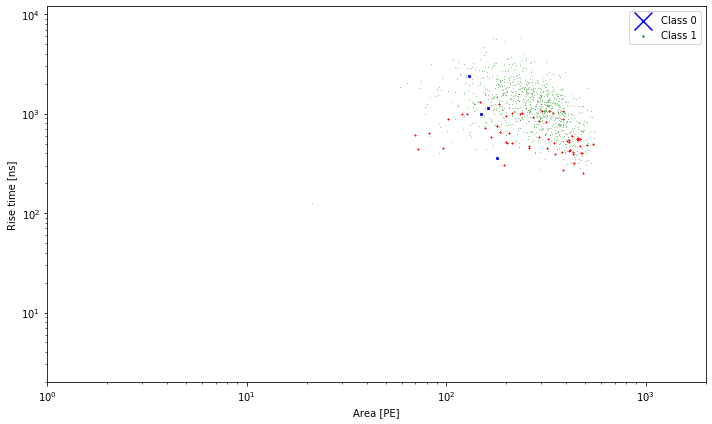

In [132]:
fig = plt.figure(figsize=(10,6))
plt.scatter(class0_arl['area'],class0_arl['rise_time'], s= 5, marker='x',color='b', label = 'Class 0')
plt.scatter(class1_arl['area'],class1_arl['rise_time'], s= 0.1, marker='.',color='g', label = 'Class 1')
#plt.scatter(class3_arl['area'],class3_arl['rise_time'], s= 1, marker='x',color='purple', label = 'Class 1')
#plt.scatter(class4_arl['area'],class4_arl['rise_time'], s= 1, marker='x',color='orange', label = 'Class 3')
plt.scatter(class2_arl['area'],class2_arl['rise_time'], s= 1, marker='x',color='red')
plt.yscale('log')
plt.ylim(2,12000)
plt.xlim(1,2e3)
plt.xscale('log')
plt.xlabel('Area [PE]')#, fontsize = 30)
plt.ylabel('Rise time [ns]')#, fontsize = 30)
plt.legend(markerscale=8)#, fontsize = 24)
plt.tight_layout()
#plt.savefig('Checks/kr83_real_data_2lbl_SOM_class.pdf')
plt.show()

In [76]:
def check_accuracy(results, truth):
    data_num = np.size(truth)
    correct_classification = 0
    for num in np.arange(data_num):
        if results[num] == truth[num]:
            correct_classification += 1
    percent_correct = correct_classification/data_num
    return percent_correct

In [102]:
def generate_confusion_mat(predicted,truth):
    import pandas as pd
    import seaborn as sn
    import matplotlib.pyplot as plt

    data = {'y_Actual':    truth,
            'y_Predicted': predicted
            }

    df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
    #df = pd.DataFrame(data, columns=['y_Predicted','y_Actual'])
    confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Ground truth'], colnames=['Predicted'], margins = True)
    #confusion_matrix = pd.crosstab(df['y_Predicted'], df['y_Actual'], rownames=['Ground truth'], colnames=['Predicted'], margins = True)
    a = confusion_matrix
    aa = np.array(a)
    v = aa[:,3]
    confusion_matrix = confusion_matrix / v[:,None]

    sn.heatmap(confusion_matrix, annot=True)
    #plt.savefig('Qual_imgs/kr83_confusion_mat_SOM.png')
    plt.show()

In [122]:
kshell_labels_bi = kshell_labels
kshell_labels_bi['type'] =np.where(kshell_labels['type'] == 3, 1, kshell_labels['type'])
kshell_labels_bi['type'] =np.where(kshell_labels['type'] == 2, -1, kshell_labels['type'])
#kshell_labels_bi =np.where(kshell_labels_bi['type'] == 3, 1, kshell_labels_bi['type'])

SOM accuracy

In [90]:
check_accuracy(kshell_labels_bi['type']+1,Kshell_data['type'] ) #need to add a +1 for shifting issues

0.9905127625931782

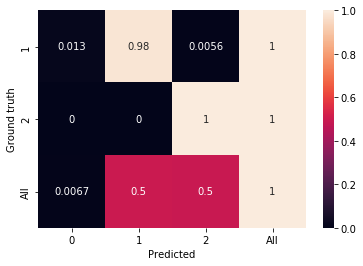

In [108]:
generate_confusion_mat(kshell_labels_bi['type']+1,Kshell_data['type'] )

In [105]:
np.max(kshell_labels_bi['type']+1)

3

In [87]:
kshell_labels_bi['type']

array([1, 1, 1, ..., 0, 0, 0], dtype=int8)

In [89]:
Kshell_data['type']

array([2, 2, 2, ..., 1, 1, 1], dtype=int8)

Strax Accuracy

In [92]:
s2_strax = kmatched_peaks[kmatched_peaks['type'] == 2]
s1_strax = kmatched_peaks[kmatched_peaks['type'] == 1]
strax_kmatched = np.concatenate((s2_strax,s1_strax))

In [97]:
check_accuracy(kmatched_peak_basics['type'],kmatched_truth['type'] )

0.9625028235825616

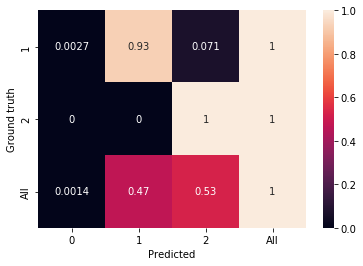

In [104]:
generate_confusion_mat(kmatched_peak_basics['type'],kmatched_truth['type'] )

No handles with labels found to put in legend.


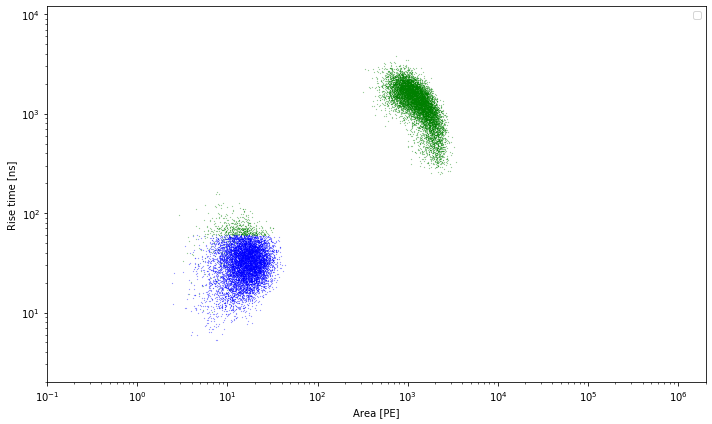

In [96]:
s2_kargon = kmatched_peak_basics[kmatched_peak_basics['type'] == 2]
s1_kargon = kmatched_peak_basics[kmatched_peak_basics['type'] == 1]
fig = plt.figure(figsize=(10,6))
plt.scatter(s2_kargon['area'],s2_kargon['rise_time'], s= 0.1, marker='.',color='g')
plt.scatter(s1_kargon['area'],s1_kargon['rise_time'], s= 0.1, marker='.',color='b')
plt.yscale('log')
plt.ylim(2,12000)
plt.xlim(0.1,2e6)
plt.xscale('log')
plt.xlabel('Area [PE]')#, fontsize = 30)
plt.ylabel('Rise time [ns]')#, fontsize = 30)
plt.legend(markerscale=8)#, fontsize = 24)
plt.tight_layout()
#plt.savefig('Checks/kr83_real_data_2lbl_SOM_class.pdf')
plt.show()

Now we check on how the L shell did, here we expect all data to be S2s

In [133]:
lshell_labels_bi = lshell_labels
lshell_labels_bi['type'] =np.where(lshell_labels['type'] == 3, 1, lshell_labels['type'])
lshell_labels_bi['type'] =np.where(lshell_labels_bi['type'] == 2, 1, lshell_labels_bi['type'])
#kshell_labels_bi =np.where(kshell_labels_bi['type'] == 3, 1, kshell_labels_bi['type'])

In [134]:
#Lshell_data = np.concatenate((lpeaks_s2,lpeaks_s1))

SOM classification Argon L shell

In [135]:
check_accuracy(lshell_labels_bi['type']+1,Lshell_data['type'] ) #need to add a +1 for shifting issues

0.9958202716823407

In [137]:
generate_confusion_mat(lshell_labels_bi['type']+1,Lshell_data['type'])

IndexError: index 3 is out of bounds for axis 1 with size 3

In [136]:
check_accuracy(lmatched_peak_basics['type'],lmatched_truth['type'])

1.0